#Chaper 3 통계적 실험과 유의성 검정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/New Hobby/데이터 과학을 위한 통계/practicalstatisticsfordatascientists/python

/content/drive/MyDrive/Colab Notebooks/New Hobby/데이터 과학을 위한 통계/practicalstatisticsfordatascientists/python


In [3]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [4]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [5]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

#3.1 A/B 검정

##용어정리
- 처리 : 어떤 대상에 주어지는 특별한 환경이나 조건
- 처리군(처리 그룹) : 특정 처리에 노출된 대상들의 집단
- 대조군(대조 그룹) : 어떤 처리도 하지 않은 대상들의 집단
- 임의화(랜덤화) : 처리를 적용할 대상을 임의로 결정하는 과정
- 대상 : 처리를 적용할 개체 대상
- 검정통계량 : 처리 효과를 측정하기 위한 지표

A/B 검정의 예시
- 종자 발아가 어디에서 더 잘되는지 알아보기 위해 두 가지 토양 처리를 검정한다.
- 두 가지 가격을 검정하여 더 많은 순이익을 산출하는 쪽을 결정한다.
- 두 개의 인터넷 광고를 검정하여 어느 것이 더 높은 전환율을 얻을 지 판단한다.

##주요개념
- 연구 대상을 두 가지 이상의 그룹 중 하나에 할당한다. 여기서 서로 다른 처리 조건을 제외한 나머지 조건들은 동일하게 처리한다.
- 이상적으로, 대상들은 그룹에 무작위로 배정한다.

#3.2 가설검정

##용어정리
- 가설검정(유의성검정) : 관찰된 효과가 우연에 의한 것인지 알아내는 과정
- 귀무가설 : 우연 때문이라는 가설
- 대립가설 : 귀무가설과의 대조 (증명하고자하는 가설)
- 일원검정 : 한 방향으로만 우연히 일어날 확률을 계산하는 가설검정
- 이원검정 : 양방향으로 우연히 일어날 확률을 계산하는 가설검정

임의성에 함정에 빠지지 말자.

확률과 실제는 구분되어 생각해야한다. 0.5의 확률을 가지는 동전던지기의 경우에도 4번의 시행에서 모두 앞면이 나올 수 있다.

가설 검정은, 그룹 간의 차이가 우연에 의해서 생기는 것이 아니라는 것을 보이기 위해,

그룹들의 결과는 동일하며 그 차이는 우연에 의해 발생한 것이라는 귀무가설을 세워,

귀무가설이 틀렸다는 것을 보이는 과정이다.

다시 말해, 가설 검정은 귀무가설을 기각하는 과정이다.

이때 결과적으로 우리가 증명해야하는 가설은 귀무가설의 대조인 대립가설이다.



- 일원 가설검정 : 방향성(단방향)을 고려한 대립가설이 필요한 경우 (B가 A보다 낫다 등) 사용. 우연에 의한 극단적인 결과에 대해 한 방향만을 고려하여 p-value를 구한다. (기본값이 지정되어있는 경우. 예를 들면 A/B 검정)

- 이원 가설 검정 : 양방향을 고려한 대립가설이 필요한 경우 (A는 B와 다르며, 더 크가나 더 작을 수 있다.) 사용. 우연에 의한 극단적인 결과가 양쪽에서 나타날 p-value를 구한다.

##주요개념
- 귀무가설은 우리가 관찰한 어떤 효과가 특별한 것이 아니고, 우연에 의해 발생한 것이라는 개념을 구체화하는 일종의 논리적 구조이다.
- 가설검정은 귀무가설이 사실이라고 가정하고, '영모형(null model)' (probalbility model)을 생성하여 관찰한 효과가 해당 모델로부터 합리적으로 나올 수 있는 결과인지를 검증하는 것이다.

#3.3 재표본추출

##용어정리
- 순열검정(permutation test) : 두 개 이상의 표본을 함께 결합하여 관측값들을 무작위로(또는 전부를) 재표본으로 추출하는 과정
- 재표본추출 : 관측 데이터로부터 반복해서 표본추출하는 과정
- 복원/비복원 : 표본 추출 시, 이미 한번 뽑은 데이터를 다음번 추출을 위해 다시 제자리에 돌려 놓거나 / 다음 추출에서 제외하는 표본 추출방법

순열 절차
1. 여러 그룹(A, B, C, D ...)의 결과를 단일 데이터 집합으로 결합한다.
2. 결합된 데이터를 잘 섞은 후, 그룹 A와 동일한 크기의 표본을 무작위로 (비복원) 추출한다.
3. 나머지 데이터에서 그룹 B와 동일한 크기의 샘플을 무작위로(비복원) 추출한다.
4. C, D 등의 그룹에 대해서도 동일한 작업을 수행한다.
  - 이제 원본 표본의 크기를 반영하는 재표본을 수집했다.
5. 원래 샘플에 대해 구한 통계량 또는 추정치가 무엇이었든 간에 지금 추출한 재표본에 대해 모두 다시 계산하고 기록한다.
  - 이것으로 한 번의 순열 반복이 진행된다,
6. 앞선 단계들을 R번 반복하여 검정통계량의 순열분포를 얻는다.

순열 분포의 결과를 통해, 관찰된 차이가 순열로 보이는 차이의 집합 안에 있다면, 관찰된 차이가 우연에 의해 발생할 수 있는 범위 안에 있다는 의미다.

하지만, 관찰된 차이의 대부분이 순열분포 바깥에 있다면, 이것을 통계적으로 유의미하다고 할 수 있다.

In [6]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

Text(0.5, 0.98, '')

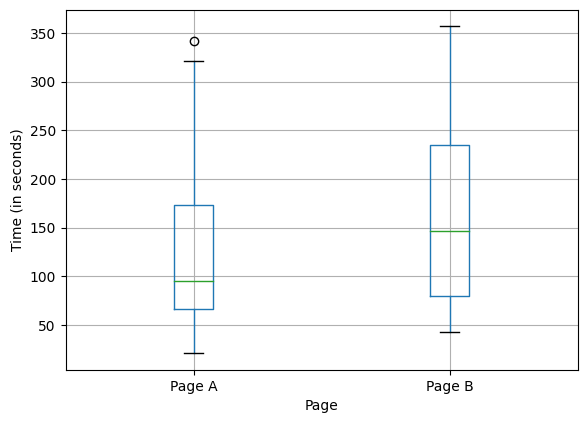

In [7]:
# 페이지에 머문 시간의 측정 분포
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.title('')
plt.suptitle('')

In [8]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(f'Difference of Each Mean: {mean_b - mean_a}')

Difference of Each Mean: 35.66666666666667


In [9]:
'''
세션시간의 차이가 통계적으로 유의미한 것인지 확인하기 위해,
모든 세션 시간을 결합한 후, 잘 섞고 21개를 A그룹에, 나머지 15개는 B그룹에 재배치한다.
'''

# nA와 nB 설정
nA = 21
nB = 15

# 순열검정 함수
def perm_fun(x, nA, nB):
  n = nA + nB
  idx_B = set(random.sample(range(n) , nB)) #nB개의 표본을 추출하고, 그룹 B에 할당한다.
  idx_A = set(range(n)) - idx_B #나머지 nA개의 표본을 그룹 A에 할당한다.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.

In [10]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)] # R=1000

<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a 

Text(0, 0.5, 'Frequency')

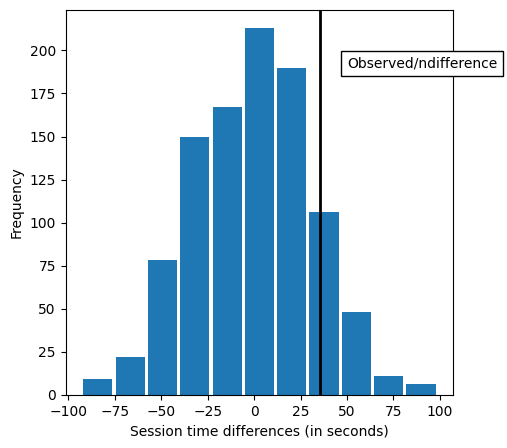

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b-mean_a, color='k', lw=2)
ax.text(50,190, 'Observed/ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

In [12]:
print(np.mean(np.array(perm_diffs) > mean_b-mean_a))
# 대부분의 80% 이상의 차이가 확률분포 범위의 내에 있다. -> 통계적으로 유의하지 않다.

0.116


- 전체순열검정(정확검정) : 데이터를 무작위로 섞고 나누는 대신, 실제로 나눌 수 있는 모든 가능한 조합을 찾는다. (샘플의 크기가 작을 때 용이)

- 부트스트랩 순열검정 : 비복원 추출 대신 '복원 추출'로 수행한다.

## 주요개념
- 순열검정에서는 여러 표본을 결합한 다음 잘 섞는다.
- 그런 다음 섞인 값들을 이용해 재표본추출 과정을 거쳐, 관심있는 표본통계량을 계산한다.
- 이 과정을 반복하고 재표본추출한 통계를 도표화한다.
- 관측된 통계량을 재표본한 분포와 비교하면 샘플 간에 관찰된 차이가 우연에 의한 것인지를 판단할 수 있다.

#3.4 통계적 유의성과 p 값

- 통계적 유의성: 통계 연구 결과가 우연히 일어난 것인지 아니면 우연히 일어날 수 없는 극단적인 것인지를 판단하는 방법

##용어정리
- p 값 (p-value) : 귀무가설을 구체화한 기회 모델이 주어졌을 때, 관측된 결과와 같이 특이하거나 극단적인 결과를 얻을 확률
- 알파 ($α$) : 실제 결과를 통계적으로 의미 있는 것으로 간주되기 위해, 우연에 의한 결과가 능가해야하는 '비정상적인' 가능성의 임계 확률
- 제 1종 오류 : 우연에 의한 효과를 실제 효과라고 잘못 결론 내리는 것
- 제 2종 오류 : 실제 효과를 우연에 의한 효과라고 잘못 결론 내리는 것

In [13]:
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed Difference: {obs_pct_diff:.4f}%')

Observed Difference: 0.0368%


<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-9-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a 

Text(0, 0.5, 'Frequency')

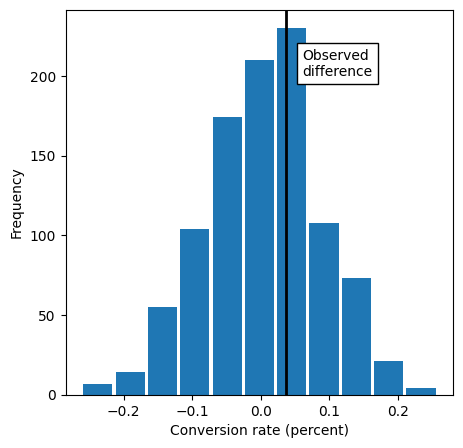

In [14]:
conversion = [0] * 45945
conversion.extend([1]*382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='k', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

In [15]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


- p-value
1. p-value는 이 데이터가 특정 통계 모델과 얼마나 상반되는지 나타낼 수 있다.
2. p-value는 연구 가설이 사실일 확률이나, 데이터가 랜덤하게 생성되었을 확률을 측정하는 것이 아니다.
3. 과학적 결론, 비즈니스나 정책 결정은 p 값이 특정 임계값을 통과하는지 여부를 기준으로 해서는 안된다.
4. 적절한 추론을 위해서는 완전한 보고와 투명성이 요구된다.
5. p-value 또는 통계적 유의성은 효과의 크기나 결과의 중요성을 의미하지는 않는다.
6. p 값 그 자체는 모델이나 가설에 대한 증거를 측정하기 위한 좋은 지표가 아니다.
---


##주요개념
- 유의성검정은 관찰된 효과가 귀무가설 모형에 대한 무작위 변이의 범위 내에 있는지 결정하는데 사용된다.
- p 값은 귀무가설로부터 나올 수 있는 결과가 관찰된 결과만큼 극단적으로 나타날 확률이다.
- 유의수준(알파)이란, 귀무가설 모델에서 '비정상'이라고 판단할 임곗값을 말한다.
- 유의성검증은 데이터 과학보다는 좀 더 공식적인 연구 보고 와 관련되어 있다.

#3.5 t 검정

##용어정리
- 검정통계량 : 관심의 차이 또는 효과에 대한 측정 지표
- t 통계량 : 평균과 가팅 표준화된 형태의 일반적인 검정통계량
- t 분포 : 관측된 t 통계량을 비교할 수 있는 (귀무가설에서 파생된) 기준분포

In [16]:
#scipy
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var = False)
print(f'p-value for single sided test: {res.pvalue / 2 :.4f}')

p-value for single sided test: 0.1408


In [17]:
#statsmodel.api
tstat, pvalue, df = sm.stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                                    session_times[session_times.Page == 'Page B'].Time,
                                    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


##주요개념
- 컴퓨터가 널리 보급되기 전에, 재표본 검정은 실용적이지 않았다. 통계학자들은 대신 표준적인 분포를 참고했다.
- 이렇게 하면 검정통계량이 표준화되어, 참고할 분포와 비교할 수 있다.
- 널리 사용되는 표준화된 통계량 중 하나가 t 통계량이다

#3.6 다중검정

##용어정리
- 제 1종 오류 : 어떤 효과가 통계적으로 유의미하다고 잘못된 결론을 내린다.
- 거짓 발견 비율(FDR) : 다중검정에서 1종 오류가 발생하는 비율
- 알파 인플레이션 : 1종 오류를 만들 확률인 알파가 더 많은 테스트를 수행할수록 증가하는 다중검정 현상.
- p 값 조정 : 동일한 데이터에 대해 다중검정을 수행하는 경우에 필요하다.
- 과대적합(오버피팅) : 잡음까지 피팅

#3.7 자유도

##용어정리
- 표본크기 (n) : 해당 데이터에서 관측값의 개수 (행 혹은 기록값의 개수와 같은 의미)
- d.f. (degree of freedom) : 자유도

##주요개념
- 자유도는 검정통계량을 표준화하는 계산의 일부이며, 이를 통해 기준 분포(t 분포, F 분포 등)와 비교할 수 있다.
- 자유도 개념은 회귀를 할 때 (다중공선성을 피하기 위해) 범주형 변수들을 n-1 지표 혹은 더미 변수로 요인화하는 것의 이유가 된다.

#3.8 분산분석

##용어정리
- ANOVA(분산분석) : 여러 그룹 간의 통계적으로 유의미한 차이를 검정하는 통계적 절차
- 쌍별 비교 : 여러 그룹 중 두 그룹 간의 가설 검정
- 총괄검정 : 여러 그룹 평균들의 전체 분산에 관한 단일 가설 검정
- 분산분해 : 구성 요소 분리, 예를 들면 전체 평균, 처리 평균, 잔차 오차로부터 개별 값들에 대한 기여를 뜻한다.
- F 통계량 : 그룹 평균 간의 차이가 랜덤 모델에서 예상되는 것에서 벗어나는 정도를 측정하는 표준화된 통계량
- SS(Sum of Squares) : 어떤 평균으로부터의 편차들의 제곱합

##ANOVA
1. 모든 데이터를 한 상자에 모은다.
2. 5개의 값을 갖는 4개의 재표본을 섞어서 추출한다.
3. 각 그룹의 평균을 기록한다.
4. 네 그룹 평균 사이의 분산을 기록한다.
5. 2~4단계를 여러 번 반복한다.

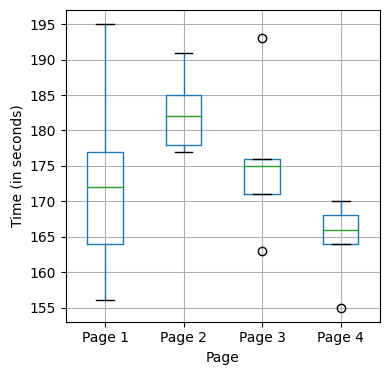

In [18]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [19]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [20]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means: ', four_sessions.groupby('Page').mean().values.ravel())
print('Variance: ', observed_variance)

def perm_test(df):
  df = df.copy()
  df['Time'] = np.random.permutation(df['Time'].values)
  return df.groupby('Page').mean().var()[0]

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob): ', np.mean([var > observed_variance for var in perm_variance]))

Observed means:  [172.8 182.6 175.6 164.6]
Variance:  55.426666666666655
Pr(Prob):  0.08333333333333333


Pr(Prob) 0.08133333333333333


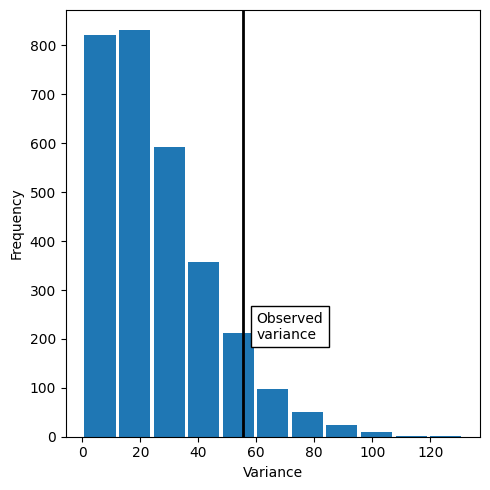

In [21]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [22]:
# F 통계량
model  = smf.ols('Time ~ Page', data = four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


In [23]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time,
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


##주요개념
- ANOVA는 여러 그룹의 실험 결과를 분석하기 위한 통계적 절차이다.
- A/B 검정과 비슷한 절차를 확장하여 그룹 간 전체적인 편차가 우연히 발생할 수 있는 범위 내에 있는지를 평가하기 위해 사용한다.
- ANOVA의 결과 중 유용한 점 중 하나는 그룹 처리, 상호작용 효과, 오차와 관련된 분산의 구성 요소들을 구분하는 데 있다.

#3.9 카이제곱검정

- 카이제곱검정은 횟수 관련 데이터에 주로 사용되며 예상되는 분포에 얼마나 잘 맞는지를 검정한다.
- 카이제곱통계량은 일반적으로 변수 간 독립성에 대한 귀무가설이 타당한지를 평가하기 위해 $r×c$ $(r:행, c:열)$ 분할표를 함께 사용한다.


##용어정리
- 카이제곱통계량 : 기댓값으로부터 어떤 관찰값까지의 거리를 나타내는 측정치
- 기댓값 : 어떤 가정(보통 귀무가설)으로부터 데이터가 발생했을 때, 그에 대해 기대하는 정도


- 피어슨 잔차
$R = \frac{관측값 - 기댓값}{\sqrt{기댓값}}$
- 카이제곱통계량 : 피어슨 잔차들의 제곱합
$X = \sum^r_i \sum^c_j R^2$

In [24]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [25]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [26]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4660


점근적 통계 이론은 카이제곱통계량의 분포가 카이제곱분포로 근사화 될 수 있음을 보여준다. 적절한 표준 카이제곱분포는 자유도에 의해 결정된다.

- $자유도 = (r-1) × (c-1)$

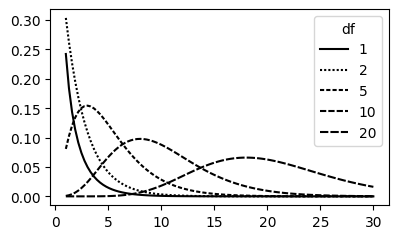

In [27]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

# 자유도에 따른 카이제곱분포
chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

In [28]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


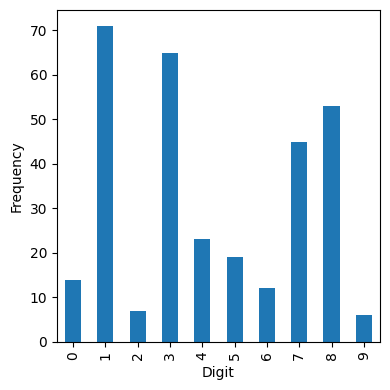

In [29]:
# 이마니시-카리 연구 데이터의 도수 히스토그램
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##주요개념
- 통계학에서 흔한 절차는 관측된 데이터가 독립성 가정(예를 들면 특정 항목을 구매하려는 성향이 성별과 무관함)을 따르는지 검증하는 것이다.
- 카이제곱분포는 카이제곱통계량을 비교할 기준분포(독립성 가정 포함)이다.

#3.10 멀티암드 밴딧 알고리즘

##용어정리
- 멀티암드 밴딧(MAB, multi-armed bandit) : 고객이 선택할 수 있는 손잡이가 여러 개인 가상의 슬롯머신을 말하며, 각 손잡이는 각기 다른 수익을 가져다준다. 다중 처리 실험에 대한 비유라고 생각할 수 있다.
- 손잡이(arm) : 실험에서 어떤 하나의 처리를 말한다.(예를 들면 '웹 테스트에서 헤드라인 A')
- 상금(수익) : 슬롯머신으로 딴 상금에 대한 실험적 비유(예를 들면 '고객들의 링크 클릭 수')

##주요개념
- 전통적 A/B 검정은 임의 표본 추출 과정을 기본으로 하기 때문에, 수익이 낮은 것을 너무 많이 시도할 수 있다.
- 이와 대조적으로 MAB는 실험 도중에 얻은 정보를 통합하고 수익이 낮은 것의 빈도를 줄이는 쪽으로 표본 추출 과정을 변경한다.
- 또한 두 가지 이상의 처리를 효과적으로 다룰 수 있다.
- 추출 확률을 수익이 낮은 처리에서 수익이 높으리라 추정되는 쪽으로 이동시키기 위한 다양한 알고리즘이 존재한다.

#3.11 검정력과 표본크기

##용어정리
- 효과크기 : '클릭의 20% 향상'과 같이 통계 검정을 통해 판단할 수 있는 효과의 최소 크기
- 검정력 : 주어진 표본크기로 주어진 효과크기를 알아낼 확률
- 유의수준 : 검정 시 사용할 통계 유의수준

In [30]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [31]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408


##주요개념
- 통계 검정을 수행하기에 앞서, 어느 정도의 표본크기가 필요한지 미리 생각할 필요가 있다.
- 알아내고자 하는 효과의 최소 크기를 지정해야한다.
- 또한 효과크기를 알아내기 위해 요구되는 확률(검정력)을 지정해야한다.
- 마지막으로, 수행할 가설검정에 필요한 유의수준을 정해야한다.